In [1]:
import tqdm
import numpy as np
import scipy.stats
import sklearn.covariance
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
sns.set_style('ticks')
palette = sns.color_palette("RdBu_r", n_colors=25)

import ulsif

In [2]:
tmis = [-0.5 * np.log(1 - c**2) for c in np.arange(0, 1, 0.1)]

In [3]:
mis = []
for c in tqdm.tqdm(np.arange(0, 1, 0.1)):
    cov = np.array([[1, c], [c, 1]])
    XY = scipy.stats.multivariate_normal(mean=[0, 0], cov=cov).rvs(1000)
    X, Y = np.split(XY, [1], axis=1)
    mis += [ulsif.mutual_information(X, Y, sigma=0.5, lamb=5e-3)]

100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


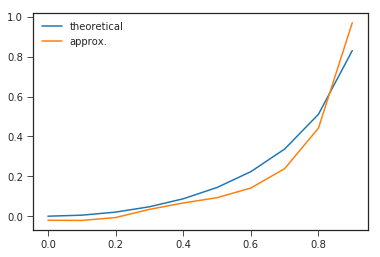

In [4]:
plt.plot(np.arange(0, 1, 0.1), tmis, label='theoretical')
plt.plot(np.arange(0, 1, 0.1), mis, label='approx.')
plt.legend()

In [5]:
pre = [[1,   0.5,    0],
       [0.5,   1, -0.4],
       [0,  -0.4,    1]]
cov = np.linalg.inv(pre)
print(np.array(pre))
X = scipy.stats.multivariate_normal(mean=[0, 0, 0], cov=cov).rvs(3000)

[[ 1.   0.5  0. ]
 [ 0.5  1.  -0.4]
 [ 0.  -0.4  1. ]]


In [6]:
d = 3
mi = np.zeros([d, d])
cmi = np.zeros([d, d])
for i, j in tqdm.tqdm([(i, j) for i in range(d) for j in range(d) if i > j]):
    mask = (np.arange(d) != i) & (np.arange(d) != j)
    mi[i, j] = mi[j, i] = ulsif.mutual_information(X=X[:, i].reshape(-1, 1), Y=X[:, j].reshape(-1, 1))
    mi_xz = ulsif.mutual_information(X=X[:, i].reshape(-1, 1), Y=X[:, mask])
    mi_yz = ulsif.mutual_information(X=X[:, j].reshape(-1, 1), Y=X[:, mask])
    mi_xyz = ulsif.mutual_information(X=X[:, i].reshape(-1, 1), Y=X[:, j].reshape(-1, 1), Z=X[:, mask])
    cmi[i, j] = cmi[j, i] = mi_xyz - (mi_xz + mi_yz)

cmi

100%|██████████| 3/3 [00:09<00:00,  3.05s/it]


array([[ 0.        , -0.0985348 , -0.19697306],
       [-0.0985348 ,  0.        , -0.13332808],
       [-0.19697306, -0.13332808,  0.        ]])

In [7]:
model = sklearn.covariance.GraphLasso(alpha=0.3, assume_centered=True)
model.fit(X)

GraphLasso(alpha=0.3, assume_centered=True, enet_tol=0.0001, max_iter=100,
      mode='cd', tol=0.0001, verbose=False)

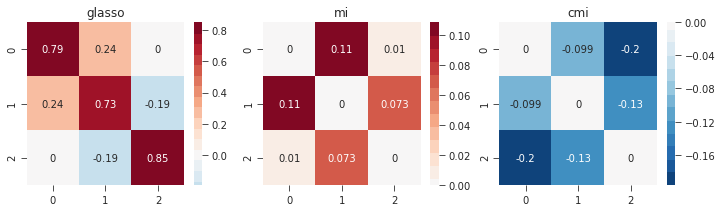

In [8]:
f, axes = plt.subplots(1, 3, figsize=[12, 3])
axes[0].set_title('glasso')
axes[1].set_title('mi')
axes[2].set_title('cmi')
sns.heatmap(model.precision_, annot=True, ax=axes[0], center=0, cmap=palette)
sns.heatmap(mi, annot=True, ax=axes[1], center=0, cmap=palette)
sns.heatmap(cmi, annot=True, ax=axes[2], center=0, cmap=palette)